In [16]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
# from deepxde.backend import tf
# Backend pytorch
import torch
# Backend jax
# import jax.numpy as jnp
# Backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend jax
    # dy_t, _ = dde.grad.jacobian(y, x, i=0, j=1)
    # dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    # return (
    #     dy_t
    #     - dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    # )
    # Backend pytorch
    return (
        dy_t
        - dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )
    # Backend jax
    # return (
    #     dy_t
    #     - dy_xx
    #     + jnp.exp(-x[:, 1:])
    #     * (jnp.sin(np.pi * x[..., 0:1]) - np.pi ** 2 * jnp.sin(np.pi * x[..., 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    train_distribution="pseudo",
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)


Compiling model...
'compile' took 0.000512 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.54e+01, 5.78e-02, 4.20e-01]    [1.63e+01, 5.78e-02, 4.20e-01]    [8.73e-01]    
1000      [1.76e-03, 2.10e-03, 3.84e-04]    [4.08e-03, 2.10e-03, 3.84e-04]    [1.54e-01]    
2000      [1.64e-03, 7.43e-04, 1.40e-04]    [1.53e-03, 7.43e-04, 1.40e-04]    [9.18e-02]    

Best model at step 2000:
  train loss: 2.52e-03
  test loss: 2.41e-03
  test metric: [9.18e-02]

'train' took 2.588930 s

Saving loss history to /Users/naujoks/Desktop/PINN-XAI/code/pinnfluence/experiments/resampling/loss.dat ...
Saving training data to /Users/naujoks/Desktop/PINN-XAI/code/pinnfluence/experiments/resampling/train.dat ...
Saving test data to /Users/naujoks/Desktop/PINN-XAI/code/pinnfluence/experiments/resampling/test.dat ...


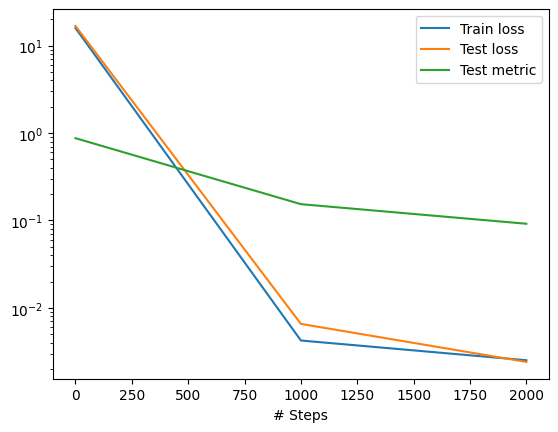

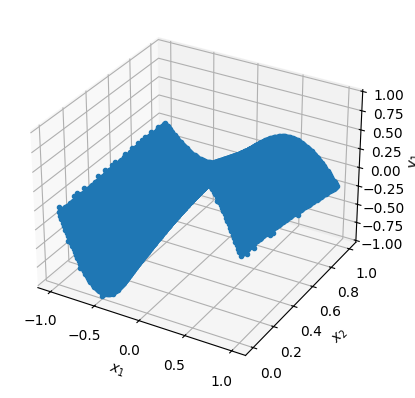

In [17]:
model = dde.Model(data, net)

resampler = dde.callbacks.PDEPointResampler(period=100, bc_points=True)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=2000, callbacks=[])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)